<a href="https://colab.research.google.com/github/tristantoupin/ECSE415-FinalProject/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import itertools    
import random as rd

#Data Preparation for CNN

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [0]:
global_path = 'gdrive/My Drive/Mcgill/U4/Fall 2018/ECSE 415/assignment/final_project/'
data_folder = 'MIO-TCD-Classification.tar'
path_to_train = 'train/'
path_to_test = 'test/'
class_ids = [x for x in os.listdir(path_to_train)]

In [0]:
# import tarfile
# print(global_path + data_folder)
# tar_f = tarfile.open(global_path + data_folder)
# tar_f.extractall()

In [0]:
def plot_images(list_of_images, max_col = 4):
    n = len(list_of_images)
    if n == 1:
        plt.imshow(list_of_images[0], cmap="gray"); plt.axis('off'); plt.show()
    else:
        # get number of columns and rows required
        r, c = 1, n
        if n > max_col:
            c = max_col
            r = int(math.ceil(n/max_col))
    
        fig = plt.figure(figsize=(20, max_col * r))
        for i, (img, name) in enumerate(list_of_images):
            ax = fig.add_subplot(r, c, (i+1))
            ax.set_title(str(class_ids[name]))
            ax.axis('off')
            ax.imshow(img, cmap="gray")

In [0]:
IMG_SIZE = 96

def small_pad_image(img, output_shape):
    BLACK = 0
    result = []
    
    h, w = img.shape
    ratio = float(output_shape)/max([h,w])
    h_n, w_n = tuple([int(val * ratio) for val in (h,w)])
    img_at_size = cv2.resize(img, (h_n, w_n))

    delta_w = output_shape - w_n
    delta_h = output_shape - h_n

    top = math.ceil(delta_h / 2)
    bot = delta_h - top
    left = math.ceil(delta_w / 2)
    right = delta_w - left        
          
    return cv2.resize(cv2.copyMakeBorder(img_at_size, 
                                       left, right, top, bot,
                                       cv2.BORDER_CONSTANT, value=0),
                               (output_shape, output_shape))

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
  
def get_train_data(path_x, path_y, num_img = -1, fraction = 1):
    X, y = [], []
    
    for c, id_ in enumerate(class_ids):
      print("Class ID: %s is changed to ID: %s." % (id_, c))
      class_imgs = os.listdir(path_to_train + id_)

      if fraction < 1:
        num_img = int(len(class_imgs) * fraction)    
        class_imgs = rd.sample(class_imgs,num_img)
      if num_img == -1:
        print("  Found %s images." % len(class_imgs))
      else:
        print("  Found %s images." % num_img)
      
      for img in class_imgs:
        img = path_to_train + id_ + '/' + img
        y.append(c)
        X.append(small_pad_image(cv2.imread(img, 0), IMG_SIZE))
        
    return unison_shuffled_copies(np.array(X), np.array(y))

In [7]:
X, y = get_train_data(path_to_train, path_to_train, fraction = 0.25)

print("\n\nFinal input shape:", X.shape)

Class ID: bicycle is changed to ID: 0.
  Found 571 images.
Class ID: work_van is changed to ID: 1.
  Found 2419 images.
Class ID: background is changed to ID: 2.
  Found 40000 images.
Class ID: bus is changed to ID: 3.
  Found 2579 images.
Class ID: motorcycle is changed to ID: 4.
  Found 495 images.
Class ID: single_unit_truck is changed to ID: 5.
  Found 1280 images.
Class ID: articulated_truck is changed to ID: 6.
  Found 2586 images.
Class ID: pickup_truck is changed to ID: 7.
  Found 12726 images.
Class ID: car is changed to ID: 8.
  Found 65129 images.
Class ID: non-motorized_vehicle is changed to ID: 9.
  Found 437 images.
Class ID: pedestrian is changed to ID: 10.
  Found 1565 images.


Final input shape: (129787, 96, 96)


In [0]:
# plot_images([(a,b) for a, b in zip(X[:16], y[:16])])

In [9]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
batch_size = 256
num_classes = 11
epochs = 40

# test and training dataset sizes
train_test_split = 0.9
split_val = int(len(X) * train_test_split)

# input image dimensions
img_rows, img_cols = X[0].shape

In [11]:
# the data, split between train and val sets
(x_train, y_train), (x_val, y_val) = (X[:split_val],y[:split_val]), (X[split_val:],y[split_val:]) 
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255
x_val /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'val samples')

x_train shape: (116808, 96, 96, 1)
116808 train samples
12979 val samples


In [0]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(x_train)
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

# val_datagen = ImageDataGenerator()
# val_datagen.fit(x_val)
# validation_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)

In [14]:
model_cnn_2 = Sequential()

model_cnn_2.add(Conv2D(32, (3, 3), activation='relu',input_shape=input_shape))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(Conv2D(32, (3, 3), activation='relu'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn_2.add(Dropout(0.1))

model_cnn_2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn_2.add(Dropout(0.1))

model_cnn_2.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn_2.add(Dropout(0.1))

model_cnn_2.add(Flatten())
model_cnn_2.add(Dense(512, activation='relu'))
model_cnn_2.add(Dropout(0.3))
model_cnn_2.add(Dense(num_classes, activation='softmax'))

optimizer = keras.optimizers.Nadam(lr=0.001,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08,
                  schedule_decay=0.004)

# Set our optimizer and loss function (similar settings to our CAE approach)
model_cnn_2.compile(loss = keras.losses.categorical_crossentropy,
            optimizer = optimizer,
            metrics = ['categorical_accuracy'])

callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                      factor=0.1, patience=5,
                      min_delta=0.0001, mode='auto',
                      cooldown=0, verbose=1, 
                      min_lr=0),
]

hist = model_cnn_2.fit_generator(train_generator,
          steps_per_epoch = x_train.shape[0] // batch_size,
          epochs=epochs,
          verbose=1, 
          validation_data=(x_val, y_val),
          callbacks = callbacks,
          )


score = model_cnn_2.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/40
228/228 [==============================] - 221s 968ms/step - loss: 1.9319 - categorical_accuracy: 0.7218 - val_loss: 0.7365 - val_categorical_accuracy: 0.7799
Epoch 2/40
228/228 [==============================] - 217s 951ms/step - loss: 0.7373 - categorical_accuracy: 0.7790 - val_loss: 0.6274 - val_categorical_accuracy: 0.8042
Epoch 3/40
228/228 [==============================] - 217s 952ms/step - loss: 0.6463 - categorical_accuracy: 0.8035 - val_loss: 0.7129 - val_categorical_accuracy: 0.7773
Epoch 4/40
228/228 [==============================] - 217s 951ms/step - loss: 0.5817 - categorical_accuracy: 0.8188 - val_loss: 0.5010 - val_categorical_accuracy: 0.8325
Epoch 5/40
228/228 [==============================] - 217s 952ms/step - loss: 0.5213 - categorical_accuracy: 0.8357 - val_loss: 0.4638 - val_categorical_accuracy: 0.8491
Epoch 6/40
228/228 [==============================] - 217s 951ms/step - loss: 0.4800 - categorical_accuracy: 0.8463 - val_loss: 0.4385 - val_categoric

In [0]:
model_cnn_2.summary()

In [0]:
y_pred = model_cnn_2.predict_classes(x_val)
# y_val_int = np.argmax(y_val, axis=1)

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_val, y_pred)
np.set_printoptions(precision=2)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[  47    0    1    0    3    0    0    0    2    0    8]
 [   0  148    1    8    0    3    2   17   79    0    0]
 [   2    0 3987    4    0    1    2    2   41    0    4]
 [   0    2    0  244    0    3    0    0    9    0    0]
 [   2    0    2    0   45    0    3    1    6    0    2]
 [   0    6    0   10    0   53   30   11    6    0    0]
 [   0    2    3   17    0   12  206    8   13    3    0]
 [   0    7    2    2    0    9    1 1014  226    0    0]
 [   0   15   13    1    1    1    3  121 6325    1    4]
 [   0    0    3    7    0    4   10    7    8    8    0]
 [   9    1    5    0    2    0    0    0    4    0  104]]
Normalized confusion matrix
[[7.70e-01 0.00e+00 1.64e-02 0.00e+00 4.92e-02 0.00e+00 0.00e+00 0.00e+00
  3.28e-02 0.00e+00 1.31e-01]
 [0.00e+00 5.74e-01 3.88e-03 3.10e-02 0.00e+00 1.16e-02 7.75e-03 6.59e-02
  3.06e-01 0.00e+00 0.00e+00]
 [4.95e-04 0.00e+00 9.86e-01 9.89e-04 0.00e+00 2.47e-04 4.95e-04 4.95e-04
  1.01e-02 

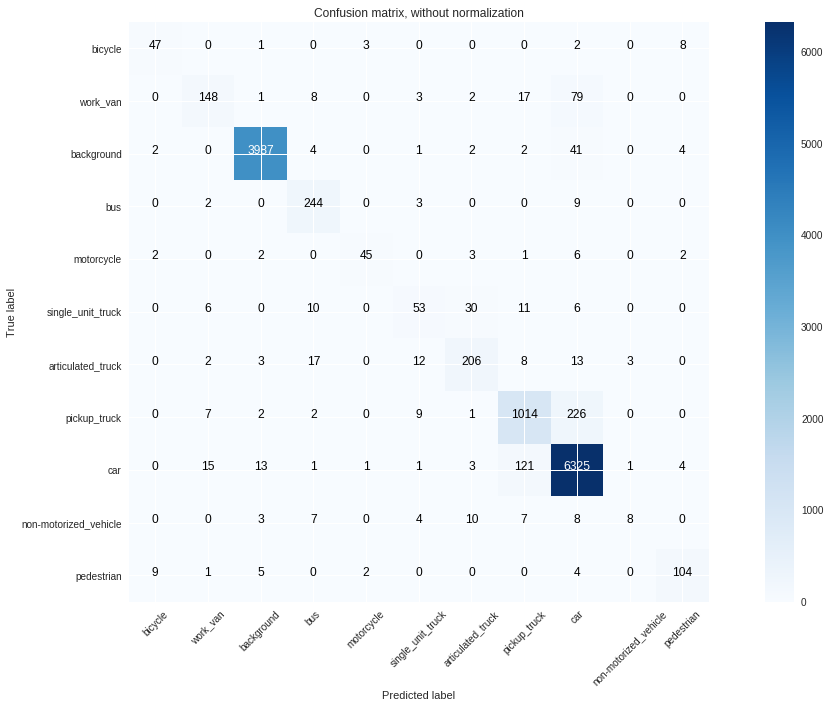

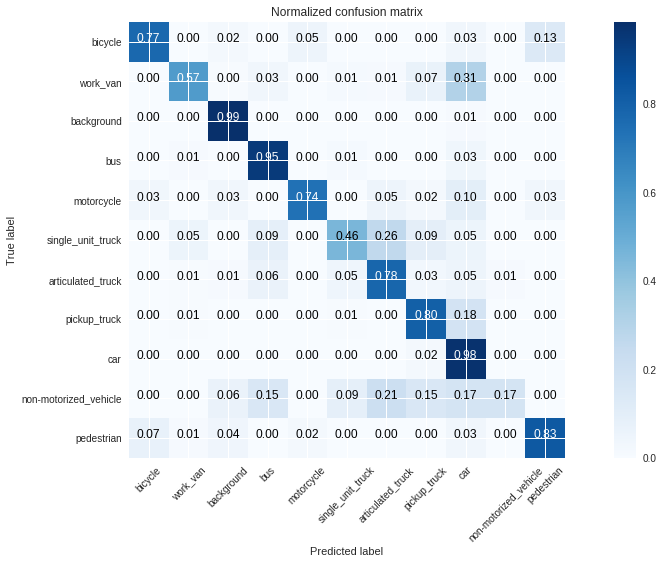

In [44]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(14, 8))
plot_confusion_matrix(cnf_matrix, classes=class_ids,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(14, 8))
plot_confusion_matrix(cnf_matrix, classes=class_ids, normalize=True,
                      title='Normalized confusion matrix')

plt.show()